# Spline Continuum Normalization
Below is an implementation of using an interpolating spline to define the continuum and normalize a spectrum.

In [1]:
import numpy as np
from scipy.interpolate import UnivariateSpline as USpline
from astropy.io import fits
import glob
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = 10, 6
def get_name(name):
    if name is None:
        return ''
    else:
        return ' - ' + name

In [3]:
files = glob.glob('../data/*.fits')
fname = files[0]
with fits.open(fname) as f:
    flux = f[1].data['flux']
    lmbd = 10**f[1].data['loglam']
    ivar = f[1].data['ivar']

In [4]:
## Cropping functions

def get_balmer(max_line):
    balmer = (np.arange(3, max_line+1))**2
    balmer = 3645.07 * (balmer/(balmer-4))
    return balmer

def crop_lines(lmbd, flux, ivar, num_lines=9, crop_wdth=100, mean_wdth=0, start=8, step_size=25):
    line_idxs = np.searchsorted(lmbd, get_balmer(num_lines))
    if type(crop_wdth) is int:
        crop_wdth = [crop_wdth] * len(line_idxs)
    elif len(crop_wdth) == 1:
        crop_wdth = [crop_wdth[0]] * len(line_idxs)

    mask = np.zeros(len(lmbd), dtype=bool)
    mask[start::step_size] = True
    mask[np.argwhere(ivar<0.1)] = False
    mask[:line_idxs[-1]] = False
    for cdx, wdth in zip(line_idxs, crop_wdth):
        lo = cdx-wdth
        hi = cdx+wdth
        mask[lo:hi] = False
    
    keep_idxs = np.concatenate(np.argwhere(mask))
    lmbd_crop = np.zeros(keep_idxs.shape)
    flux_crop = np.zeros(keep_idxs.shape)
    ivar_crop = np.zeros(keep_idxs.shape)
    for i in range(len(keep_idxs)):
        keep = keep_idxs[i]
        lmbd_crop[i] = np.mean(lmbd[keep-mean_wdth:keep+mean_wdth+1])
        flux_crop[i] = np.mean(flux[keep-mean_wdth:keep+mean_wdth+1])
        ivar_crop[i] = np.sqrt(np.sum(ivar[keep-mean_wdth:keep+mean_wdth+1]**2))

    return lmbd_crop, flux_crop, ivar_crop

def plot_cropped(lmbd, lmbd_crop, flux, flux_crop, ivar=None, ivar_crop=None, name=None, ylim=(0, 140)):
    plt.title('Cropped Regions' + get_name(name))
    plt.errorbar(lmbd, flux, yerr=(None if ivar is None else 1/ivar), label='raw data')
    plt.errorbar(lmbd_crop, flux_crop, yerr=(None if ivar_crop is None else 1/ivar_crop), label='cropped')
    plt.ylim(ylim)
    plt.legend()
    plt.show()

In [5]:
## Continuum normalization functions

def get_spline(lmbd, flux, ivar, degree=1, smooth=100):
    return USpline(lmbd, flux, w=ivar, k=degree, s=smooth, ext=0)

def get_cont_norm(spline, lmbd, flux):
    cont = spline(lmbd)
    norm = flux/cont
    return cont, norm

def plot_cont(lmbd, cont, flux=None, name=None, legend=True):
    plt.title('Continuum' + get_name(name))
    if flux is not None:
        plt.plot(lmbd, flux, label='data')
    plt.plot(lmbd, cont, label='continuum')
    if legend:
        plt.legend()
    plt.show()

def clip_norm(norm, b_lim=0, u_lim=2):
    norm[np.argwhere(norm>u_lim)] = 1
    norm[np.argwhere(norm<b_lim)] = 1
    return norm

def plot_norm(lmbd, norm, name=None, ylim=(0,2)):
    plt.title('Normalization' + get_name(name))
    plt.plot(lmbd, norm)
    plt.ylim(ylim)
    plt.show()

In [6]:
## Specific implementation

def basic(lmbd=lmbd, flux=flux, ivar=ivar, name=None, plot=True):
    lmbd_crop, flux_crop, ivar_crop = crop_lines(lmbd, flux, ivar)
    spl = get_spline(lmbd_crop, flux_crop, ivar_crop)
    cont, norm = get_cont_norm(spl, lmbd, flux)
    norm = clip_norm(norm)

    if plot:
        plot_cropped(lmbd, lmbd_crop, flux, flux_crop, ivar, ivar_crop, name=name)
        plot_cont(lmbd, cont, flux=flux, name=name)
        plot_norm(lmbd, norm, name=name)
    else:
        return spl, cont, norm

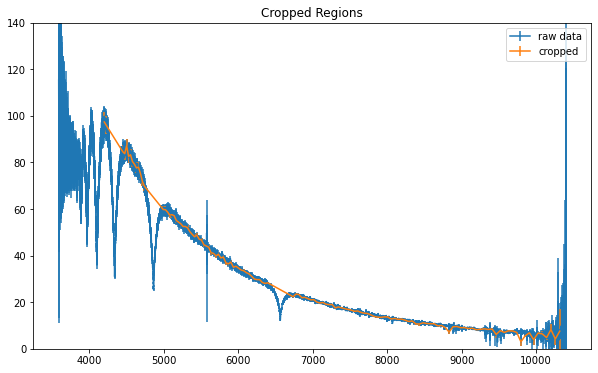

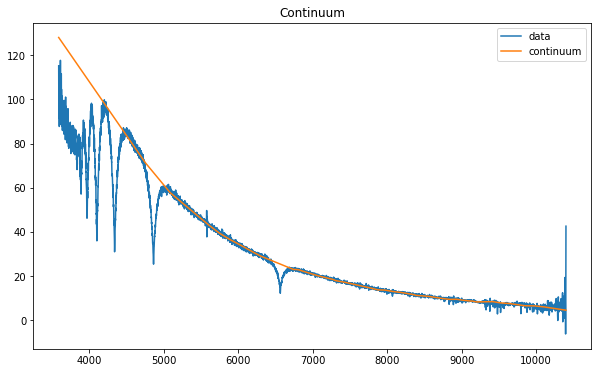

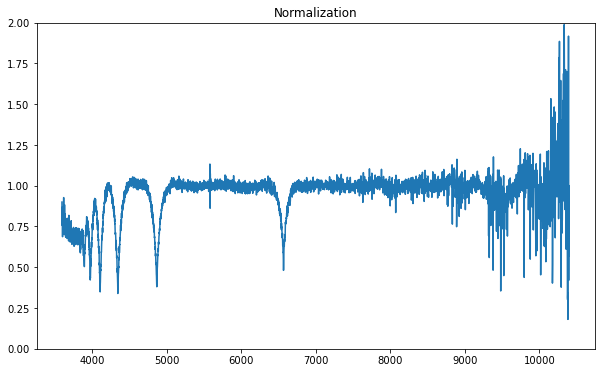

In [7]:
basic()

## Second Spline Method
Below, a second, linear spline is run on the original spline.

In [8]:
def spline_squared(lmbd=lmbd, flux=flux, ivar=ivar, name=r'$spline^2$', plot=True):
    spl, cont, norm = basic(plot=False)
    spl_2 = get_spline(lmbd, cont, None)
    cont_2, norm_2 = get_cont_norm(spl_2, lmbd, flux)
    norm_2 = clip_norm(norm_2)

    if plot:
        plot_cont(lmbd, cont_2, flux=flux, name=name)
        plot_norm(lmbd, norm_2, name=name)
    else:
        return spl_2, cont_2, norm_2

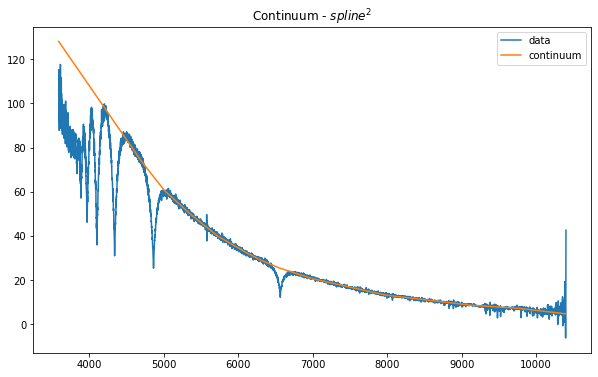

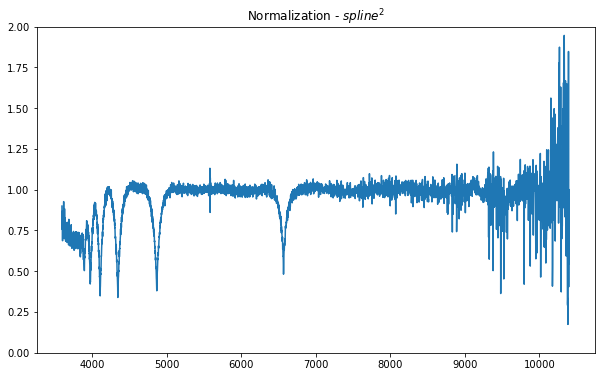

In [9]:
spline_squared()

## Mean of Selected Points
Below, a modification of the cropped points is implemented: for each selected point, the surrounding points are averaged together to reduce the noise picked up by the spline knots.

In [10]:
def crop_mean(lmbd=lmbd, flux=flux, ivar=ivar, mean_wdth=3, name='Crop-mean', plot=True):
    lmbd_mean, flux_mean, ivar_mean = crop_lines(lmbd, flux, ivar, mean_wdth=mean_wdth)
    spl_mean = get_spline(lmbd_mean, flux_mean, ivar_mean)
    cont_mean, norm_mean = get_cont_norm(spl_mean, lmbd, flux)
    norm_mean = clip_norm(norm_mean)

    if plot:
        plot_cropped(lmbd, lmbd_mean, flux, flux_mean, ivar, ivar_mean, name=name)
        plot_cont(lmbd, cont_mean, flux=flux, name=name)
        plot_norm(lmbd, norm_mean, name=name)
    else:
        return spl_mean, cont_mean, norm_mean

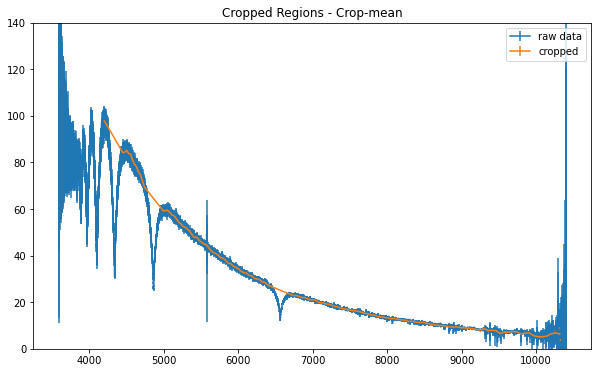

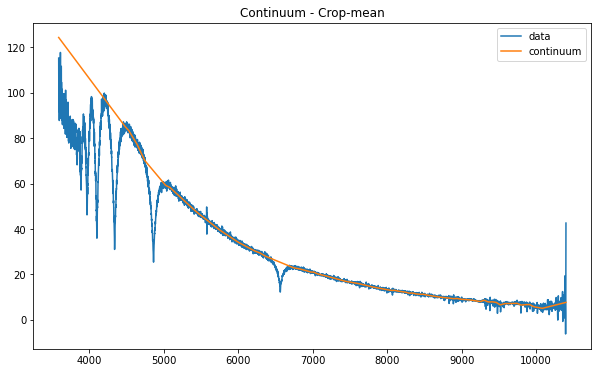

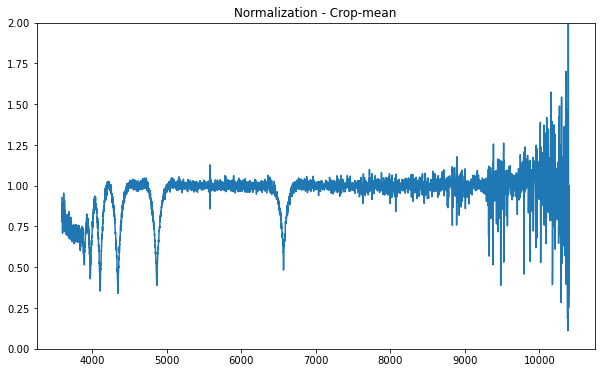

In [11]:
crop_mean()

## Decreasing Crop Window Sizes
Below, a modification of the cropping function with decreasing crop window sizes is implemented.

In [12]:
def decr_crop(lmbd=lmbd, flux=flux, ivar=ivar, wndw_init=100, wndw_step=-4, name='Decr-crop', plot=True):
    decr_wndw = np.arange(wndw_init, wndw_init + 9*wndw_step, wndw_step)
    lmbd_decr, flux_decr, ivar_decr = crop_lines(lmbd, flux, ivar, crop_wdth=decr_wndw)
    spl_decr = get_spline(lmbd_decr, flux_decr, ivar_decr)
    cont_decr, norm_decr = get_cont_norm(spl_decr, lmbd, flux)
    norm_decr = clip_norm(norm_decr)

    if plot:
        plot_cropped(lmbd, lmbd_decr, flux, flux_decr, ivar, ivar_decr, name=name)
        plot_cont(lmbd, cont_decr, flux=flux, name=name)
        plot_norm(lmbd, norm_decr, name=name)
    else:
        return spl_decr, cont_decr, norm_decr

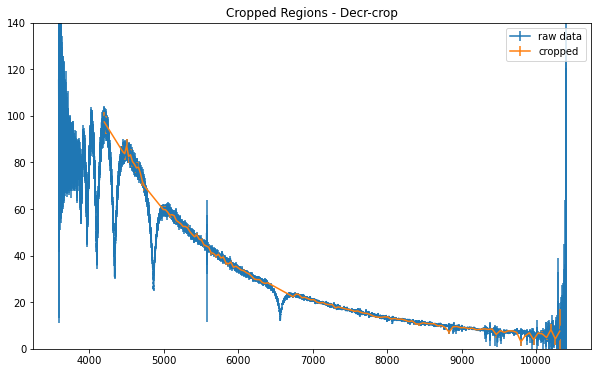

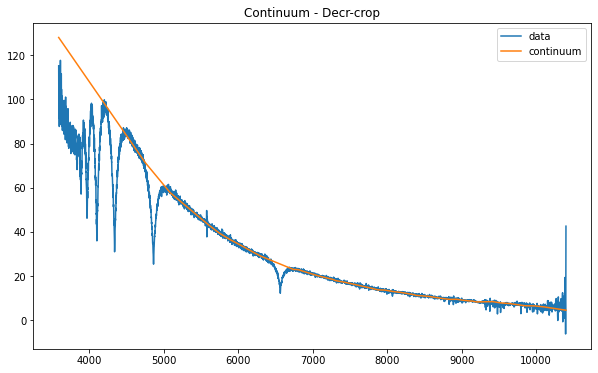

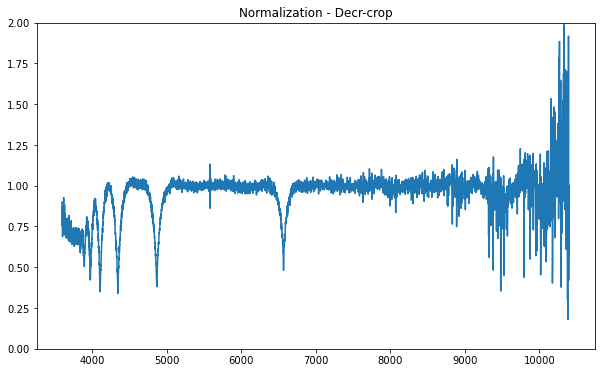

In [13]:
decr_crop()

## Combining Mean and Decreasing Window Sizes

In [14]:
def decr_crop_mean(lmbd=lmbd, flux=flux, ivar=ivar, wndw_init=100, wndw_step=-4, mean_wdth=4, name='Decr-mean', plot=True):
    decr_wndw = np.arange(wndw_init, wndw_init + 9*wndw_step, wndw_step)
    lmbd_dcmn, flux_dcmn, ivar_dcmn = crop_lines(lmbd, flux, ivar, crop_wdth=decr_wndw, mean_wdth=mean_wdth)
    spl_dcmn = get_spline(lmbd_dcmn, flux_dcmn, ivar_dcmn)
    cont_dcmn, norm_dcmn = get_cont_norm(spl_dcmn, lmbd, flux)
    norm_dcmn = clip_norm(norm_dcmn)

    if plot:
        plot_cropped(lmbd, lmbd_dcmn, flux, flux_dcmn, ivar, ivar_dcmn, name=name)
        plot_cont(lmbd, cont_dcmn, flux=flux, name=name)
        plot_norm(lmbd, norm_dcmn, name=name)
    else:
        return spl_dcmn, cont_dcmn, norm_dcmn

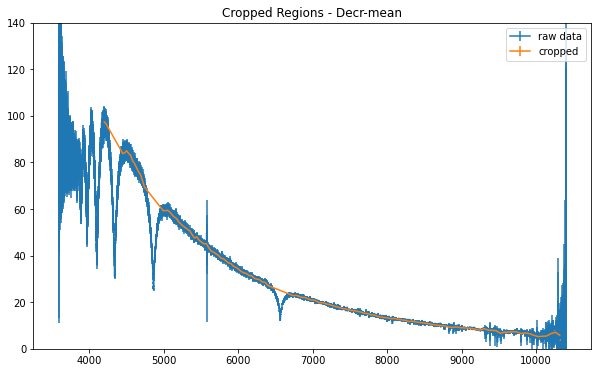

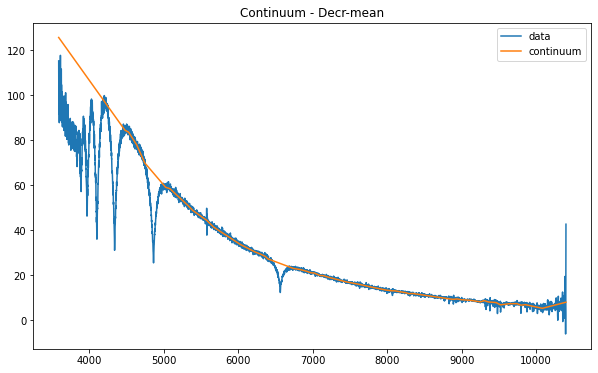

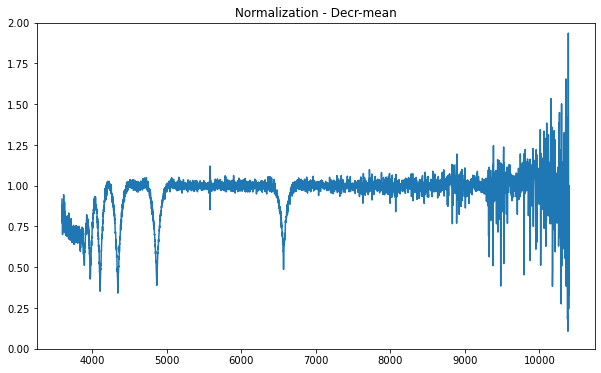

In [15]:
decr_crop_mean()

## Randomly sampling points (i.e. non-periodic sampling of points)

In [16]:
# see last section, not implemented independently

# Bringing it all together

In [17]:
class ContNormSpline:
    def __init__(self, lmbd, flux, ivar,
				 name=None,
				 spln_degr=1,
				 spln_smth=100,
				 num_lines=9,
				 wndw_init=100,
				 wndw_step=0,
				 crop_rand=0,
				 mean_wdth=0,
				 crop_strt=8,
				 crop_step=25,
				 spl_2=False):
        '''
		Initializes all cropping and spline properties.

		name	  - the name of this spline for the generated plots.
		spln_degr - the degree of interpolation spline polynomials. spln_degr must be between [1, 5]
		spln_smth - the smoothing factor for the interpolation spline.
		num_lines - the last Balmer line to directly crop, all data points bluewards of this line
					are ignored. num_lines must be an int >= 3.
		crop_wdth - the number of indices to crop out on both sides of each Balmer line (note that
					2*crop_wdth+1 indices will be ignored). If `crop_wdth` is an array, the crop
					width for each line is set individually.
		crop_rand - the width of the random window for the center of each cropped index.
		mean_wdth - the number of indices to collect on both sides of each selected index to take
					the mean of (note that 2*mean_wdth+1 indices will be used). mean_wdth is an int.
		crop_strt - the index in the wavelength array to start sampling at. All indices less than
					start are ignored.
		crop_step - the step size for the sampling of indices. only one index every step_size indies
					will be included in the output arrays.
		spl_2	  - whether a second spline should be run on the initially constructed spline.
		'''
        self.lmbd = lmbd
        self.flux = flux
        self.ivar = ivar
        self.__xlen = len(lmbd)
        self.name = self.__get_name(name)
        self.spln_degr = spln_degr
        self.spln_smth = spln_smth
        self.line_idxs = np.searchsorted(self.lmbd, self.__get_balmer(num_lines))
        self.crop_wdth = self.__crop_wdth(num_lines, wndw_init, wndw_step)
        self.crop_rand = crop_rand
        self.mean_wdth = mean_wdth
        self.crop_strt = crop_strt
        self.crop_step = crop_step
        self.spl_2 = spl_2
    
    def __get_balmer(self, max_line):
        # generate Balmer lines
        balmer = (np.arange(3, max_line+1))**2
        balmer = 3645.07 * (balmer/(balmer-4))
        return balmer
    
    def __get_name(self, name):
        # name for titles
        if name is None:
            return ''
        else:
            return ' - ' + name
    
    def __crop_wdth(self, num_lines, wndw_init, wndw_step):
        # convert Balmer line crop window into required format
        if wndw_step != 0:
            return np.arange(wndw_init, wndw_init + num_lines*wndw_step, wndw_step)
        else:
            return np.full((num_lines,), wndw_init)

    def crop(self):
        '''
        Given the wavelength, flux, and inverse variance arrays, crops out the Balmer lines and
        samples a certain number of random points to prepare the arrays for spline fitting.
        '''
        mask = np.zeros(self.__xlen, dtype=bool)

        # crop random
        unif = np.arange(self.crop_strt, self.__xlen, self.crop_step)
        rand = np.random.randint(-self.crop_rand, self.crop_rand+1, size=len(unif))
        idxs = unif + rand
        if idxs[-1] >= self.__xlen:
            idxs[-1] = self.__xlen-1
        mask[idxs] = True

        # crop lines
        mask[np.argwhere(self.ivar<0.1)] = False
        mask[:self.line_idxs[-1]] = False
        for cdx, wdth in zip(self.line_idxs, self.crop_wdth):
            lo = cdx-wdth
            hi = cdx+wdth
            mask[lo:hi] = False
        
        # crop mean
        keep_idxs = np.concatenate(np.argwhere(mask))
        self.lmbd_crop = np.zeros(keep_idxs.shape)
        self.flux_crop = np.zeros(keep_idxs.shape)
        self.ivar_crop = np.zeros(keep_idxs.shape)
        for i in range(len(keep_idxs)):
            keep = keep_idxs[i]
            self.lmbd_crop[i] = np.mean(self.lmbd[keep-self.mean_wdth:keep+self.mean_wdth+1])
            self.flux_crop[i] = np.mean(self.flux[keep-self.mean_wdth:keep+self.mean_wdth+1])
            self.ivar_crop[i] = np.sqrt(np.sum(self.ivar[keep-self.mean_wdth:keep+self.mean_wdth+1]**2))
    
    def plot_crop(self, legend=True, ylim=(0,140)):
        plt.title('Cropped Regions' + self.name)
        plt.errorbar(self.lmbd, self.flux, yerr=1/self.ivar, label='raw data')
        plt.errorbar(self.lmbd_crop, self.flux_crop, yerr=1/self.ivar_crop, label='cropped')
        plt.ylim(ylim)
        if legend:
            plt.legend()
        plt.show()

    def construct_spline(self):
        self.spline = USpline(self.lmbd_crop, self.flux_crop, w=self.ivar_crop, k=self.spln_degr, s=self.spln_smth)
        self.blue_most = self.lmbd_crop[0]

        # get blue extrapolation
        frst_derv = self.spline.derivative()
        drvs = frst_derv(lmbd)
        x_4k, x_5k, x_6k, x_8k, x_9k, x_Tk = np.searchsorted(lmbd, (4000, 5000, 6000, 8000, 9000, 10000))

        dr4k = np.mean(drvs[x_4k:x_5k]) # derivative centered on 4500
        dr5k = np.mean(drvs[x_5k:x_6k]) # derivative centered on 5500
        lb4k = np.mean(lmbd[x_4k:x_5k]) # exact lambda, roughly 4500
        lb5k = np.mean(lmbd[x_5k:x_6k]) # exact lambda, roughly 5500
        scnd_derv = (dr4k - dr5k) / (lb4k - lb5k) # get second derivative between these two points

        dist = (self.blue_most - self.lmbd[0]) / 2 # distance to middle of extrapolated section
        b_fl, b_sl = self.spline.derivatives(self.blue_most) # get flux, slope at blue-most kept point
        slop = b_sl - scnd_derv * dist
        intr = b_fl - slop * self.blue_most
        self.blue_slop = slop
        self.blue_intr = intr

        if self.spl_2:
            self.compute_cont_norm()
            self.spline = USpline(self.lmbd, self.cont, w=self.ivar, k=self.spln_degr, s=self.spln_smth)
            self.blue_most = 0
            self.cont = None
            self.norm = None

    def eval(self, x):
        return np.where(x < self.blue_most, self.blue_intr + self.blue_slop * x, self.spline(x))
    
    def compute_cont_norm(self):
        self.cont = self.eval(self.lmbd)
        self.norm = self.flux / self.cont
        self.__clip_norm()
    
    def __clip_norm(self, b_lim=0, u_lim=2):
        # clip values beyond b_lim or u_lim to exactly 1
        self.norm[np.argwhere(self.norm>u_lim)] = 1
        self.norm[np.argwhere(self.norm<b_lim)] = 1
    
    def plot_cont(self, legend=True, ylim=(0, 140)):
        plt.title('Continuum' + self.name)
        plt.plot(self.lmbd, self.flux, label='data')
        plt.plot(self.lmbd, self.cont, label='continuum')
        plt.ylim(ylim)
        if legend:
            plt.legend()
        plt.show()

    def plot_norm(self, legend=True, ylim=(0,2)):
        plt.title('Normalization' + self.name)
        plt.plot(self.lmbd, self.norm, label='normalized')
        plt.plot(self.lmbd, [1] * self.__xlen, 'k', label='1')
        plt.ylim(ylim)
        if legend:
            plt.legend()
        plt.show()
    
    def run_all(self, plot=True):
		# runs all of the requisite functions to compute the continuum and normalized fluxes
        self.crop()
        self.construct_spline()
        self.compute_cont_norm()

        if plot:
            self.plot_crop()
            self.plot_cont()
            self.plot_norm()


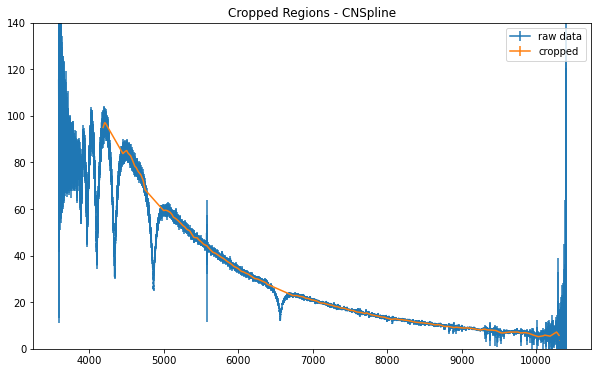

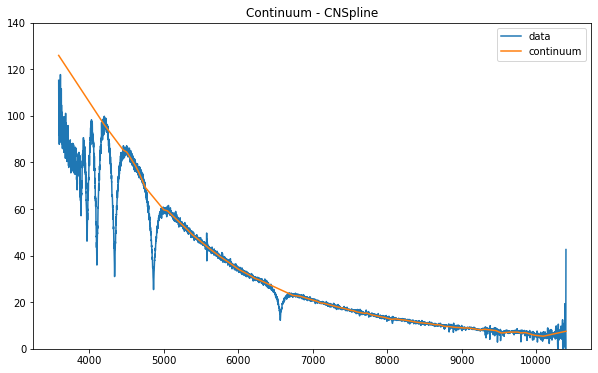

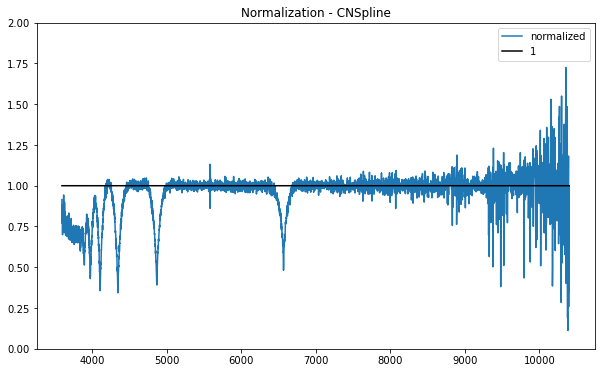

In [18]:
cnspl = ContNormSpline(lmbd, flux, ivar, name='CNSpline', wndw_step=-4, mean_wdth=5, crop_rand=10)
cnspl.run_all()

In [19]:
%timeit cnspl.run_all(plot=False)

8.25 ms ± 457 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
